# Исследование минимумов на графики энтропии от времени

In [1]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import qutip
from tqdm import tqdm

In [2]:
import sys
import pathlib

sys.path.append(str(pathlib.Path(sys.path[0]).parent / "libs"))

In [3]:
%reload_ext autoreload
%autoreload 2

import bec
import entanglement_propagation
from tools.jupyter import print_model_info
from tools.qutip import TqdmProgressBar

## Сравнение графиков энтропии для пары кубитов с разными количеством базонов 

### Двухкубитная цепочка

In [4]:
%%time

pe_task = entanglement_propagation.PropagateEntanglementTask(
    n_bosons=4,
    n_sites=2,
    t_span=(0, 0.8, 100),
)
pe_result = pe_task.run(n_jobs=1)

model_ = bec.BEC_Qubits.init_default(pe_task.n_bosons, 0)
states_exact = [qutip.ptrace(bec.state_under_h_zz_teor(model_, t / model_.Omega), [2, 3]) for t in tqdm(pe_result.t_list)]

100%|██████████| 100/100 [00:00<00:00, 165.55it/s]

CPU times: user 657 ms, sys: 16.9 ms, total: 674 ms
Wall time: 670 ms


100%|██████████| 100/100 [00:01<00:00, 51.09it/s]


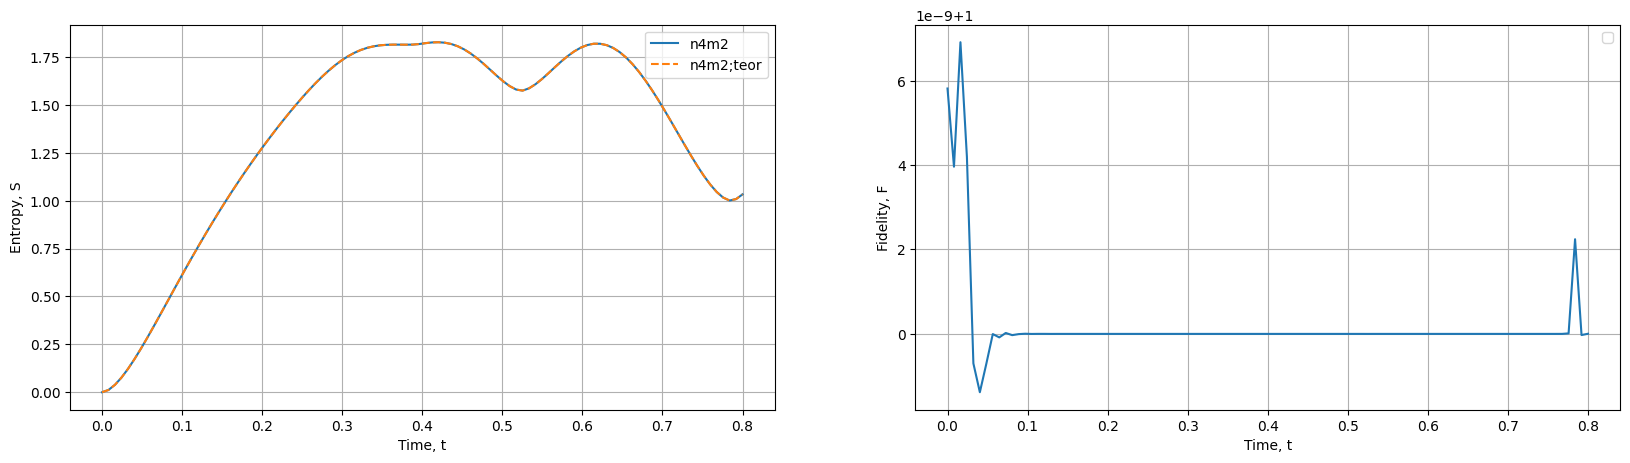

In [5]:
entropies = pe_result.entropies()
entropies_exact = [qutip.entropy.entropy_vn(s, base=2) for s in tqdm(states_exact)]

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

ax = axes[0]
ax.plot(pe_result.t_list, entropies, label=pe_task.label)
ax.plot(pe_result.t_list, entropies_exact, "--", label=f"n{model_.n_bosons}m2;teor")

ax.set_xlabel("Time, t")
ax.set_ylabel("Entropy, S")
ax.grid()
ax.legend()


fids = [qutip.metrics.fidelity(pe_result.reveal_state(i), s_e) for i, s_e in enumerate(tqdm(states_exact))]
ax = axes[1]
ax.plot(pe_result.t_list, fids)
ax.set_xlabel("Time, t")
ax.set_ylabel("Fidelity, F")
ax.grid()
ax.legend()

## Пример матрицы плотности в пространства операторов $а$ и $b$

В дейстительности не нулевыми элементами являются только фоковские состояния. 
Не нулевые элементы укладываются в матрицу $N+1$, вместо $2*(N + 1)$

In [6]:
m = bec.BEC_Qubits.init_default(3, 0) 
s = qutip.ptrace(bec.state_under_h_zz_teor(m, 0.4 / m.Omega), [0, 1])
sp.Matrix(s) 

NameError: name 'sp' is not defined

## Цепочки разной длины

### Исследуем след матриц

100%|██████████| 100/100 [00:00<00:00, 213.11it/s]


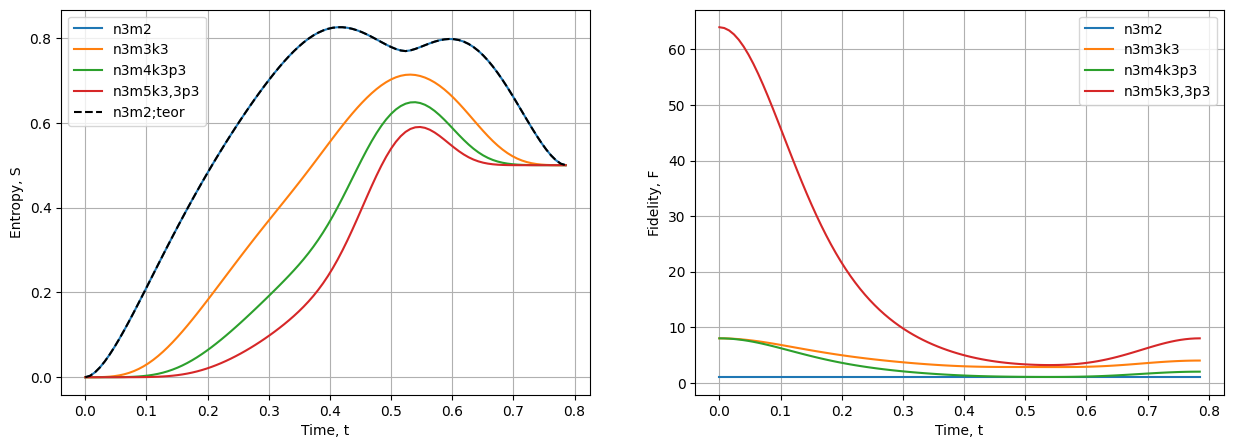

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for m in [2, 3, 4, 5]:
    pe_task = entanglement_propagation.PropagateEntanglementTask(
        n_bosons=3,
        n_sites=m,
        t_span=(0, np.pi / 4, 100),
    )
    model_ = bec.BEC_Qubits.init_default(pe_task.n_bosons, 0)
    
    pe_result = pe_task.run()
    traces = [pe_result.reveal_state(i).tr() for i, _ in enumerate(tqdm(pe_result.t_list))]
   
    axes[0].plot(pe_result.t_list, pe_result.entropies() / np.log2(pe_task.n_bosons + 1), label=pe_task.label)
    axes[1].plot(pe_result.t_list, traces, label=pe_task.label)
    

model_ = bec.BEC_Qubits.init_default(pe_task.n_bosons, 0)
axes[0].plot(
    pe_result.t_list, 
    [
        qutip.entropy.entropy_vn(qutip.ptrace(s, [0, 1]), base=2) / np.log2(pe_task.n_bosons + 1)
        for s in (bec.state_under_h_zz_teor(model_, t / model_.Omega) for t in tqdm(pe_result.t_list))
    ],
    "--k",
    label=f"n{model_.n_bosons}m2;teor"
)

axes[0].set_xlabel("Time, t")
axes[0].set_ylabel("Entropy, S")
axes[0].grid()
axes[0].legend()


axes[1].set_xlabel("Time, t")
axes[1].set_ylabel("Fidelity, F")
axes[1].grid()
axes[1].legend()

### Энтропия и фиделити

100%|██████████| 301/301 [00:13<00:00, 21.88it/s, n10m5k10,10p10;fids]


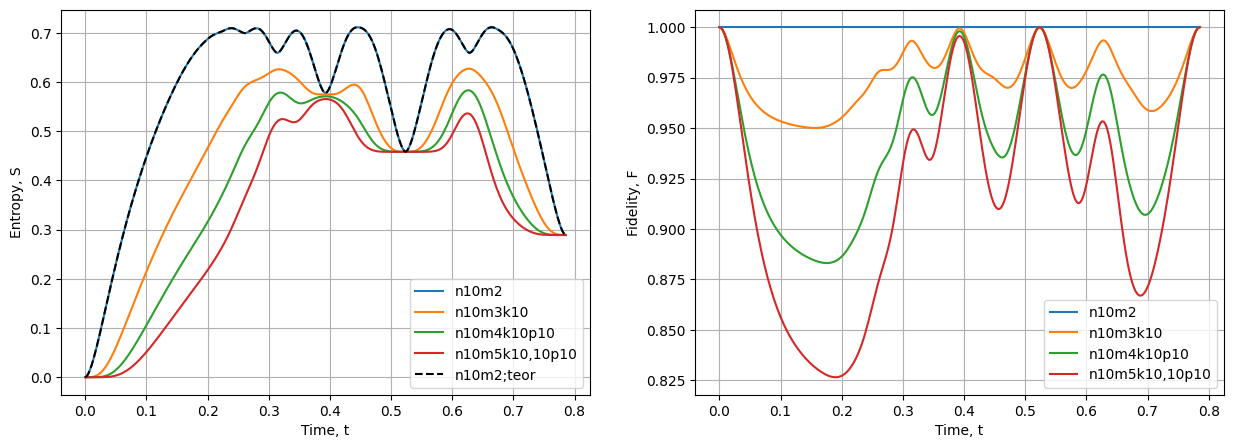

In [8]:
n_bosons = 10
t_span = (0, np.pi / 4, 301)

n_jobs = -2

t_list = np.linspace(*t_span)
model_ = bec.BEC_Qubits.init_default(n_bosons, 0)
states_true = joblib.Parallel(n_jobs=n_jobs)(
    joblib.delayed(qutip.ptrace)(bec.state_under_h_zz_teor(model_, t / model_.Omega), [0, 1])
    for t in tqdm(t_list, postfix=f"n{model_.n_bosons}m2;teor")
)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for m in [2, 3, 4, 5]:#, 6, 7]:
    pe_task = entanglement_propagation.PropagateEntanglementTask(
        n_bosons=n_bosons,
        n_sites=m,
        t_span=t_span,
    )
    pe_result = pe_task.run(n_jobs=n_jobs)
    fids = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(lambda i, s_e: qutip.metrics.fidelity((x := pe_result.reveal_state(i)) / x.tr(), s_e))(i, s_e) 
        for i, s_e in enumerate(tqdm(states_true, postfix=f"{pe_task.label};fids"))
    )
   
    axes[0].plot(pe_result.t_list, pe_result.entropies() / np.log2(pe_task.n_bosons + 1), label=pe_task.label)
    axes[1].plot(pe_result.t_list, fids, label=pe_task.label)
    

model_ = bec.BEC_Qubits.init_default(pe_task.n_bosons, 0)
axes[0].plot(
    pe_result.t_list, [qutip.entropy.entropy_vn(s, base=2) / np.log2(pe_task.n_bosons + 1) for s in states_true],
    "--k",
    label=f"n{model_.n_bosons}m2;teor"
)

axes[0].set_xlabel("Time, t")
axes[0].set_ylabel("Entropy, S")
axes[0].grid()
axes[0].legend()


axes[1].set_xlabel("Time, t")
axes[1].set_ylabel("Fidelity, F")
axes[1].grid()
axes[1].legend()